In [2]:
# cellules générales, à exécuter en premier

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_validate, ValidationCurveDisplay, GridSearchCV
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]


# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback=None, limit_size=None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path, file_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)

In [7]:
datasetX = []
datasetY = []

image_size = (100, 100)


def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    datasetX.append(new_img)
    datasetY.append(category)


browse_imgs(load_datasets)
datasetX = np.array(datasetX).reshape(-1, image_size[0] * image_size[1])
trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
print("Dataset shape : ", datasetX.shape)

Dataset shape :  (5856, 10000)



# A prendre pour la prochaine fois

la boucle for qui stock les means et std au lieux des res de chaque fold

In [8]:
def cross_val(model, scoring, nb_folds=5):
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, error_score="raise",
                        return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    for dataset_key in res:
        mean = res[dataset_key].mean()
        std = res[dataset_key].std()
        res[dataset_key] = {"mean": mean, "std": std}
    return pd.DataFrame(res)

In [9]:
def calcul_and_show_confusion_matrix(model):
    model.fit(trainx, trainy)

    y_pred = model.predict(testx)
    recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
    precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
    f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
    print("recall : ", recall)
    print("precision : ", precision)
    print("f1score : ", f1score)

    cm = confusion_matrix(testy, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

In [10]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA")
}

      test_recall  train_recall  test_precision  train_precision   test_f1  \
mean     0.951789           1.0        0.943803              1.0  0.946450   
std      0.018855           0.0        0.054453              0.0  0.023254   

      train_f1  
mean       1.0  
std        0.0  
recall :  0.966743119266055
precision :  0.9612314709236032
f1score :  0.9639794168096055


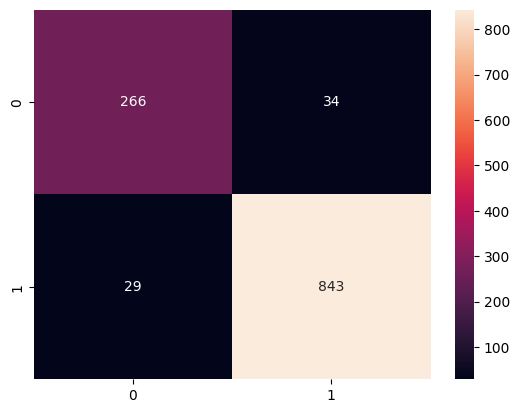

In [9]:
model = LogisticRegression(max_iter=1000)

print(cross_val(model, general_scoring))

calcul_and_show_confusion_matrix(model)

In [10]:
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
#     'penalty': ['l2', 'none']
# }

# model = LogisticRegression(max_iter=1000)

# grid_search = GridSearchCV(model, param_grid, cv=4, scoring=general_scoring, refit="f1", verbose=3, return_train_score=True)
# grid_search.fit(datasetX, datasetY)

# print("best params : ", grid_search.best_params_)

# model = grid_search.best_estimator_

# print(cross_val(model, general_scoring))

# calcul_and_show_confusion_matrix(model)

# Logistic regression 

c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached w

      test_recall  train_recall  test_precision  train_precision   test_f1  \
mean     0.953895      0.999532        0.951264              1.0  0.951288   
std      0.018537      0.000234        0.054571              0.0  0.023630   

      train_f1  
mean  0.999766  
std   0.000117  
recall :  0.9644495412844036
precision :  0.9622425629290617
f1score :  0.9633447880870561


c:\Users\Timothée\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


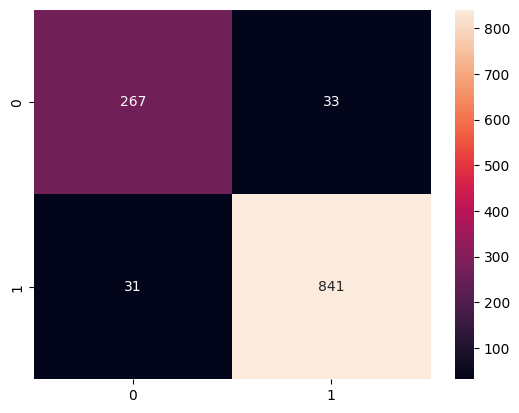

In [11]:
model = LogisticRegression(max_iter=2000, C= 0.1, penalty= 'l2', solver= 'saga', class_weight='balanced')

print(cross_val(model, general_scoring))

calcul_and_show_confusion_matrix(model)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
best params :  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
      test_recall  train_recall  test_precision  train_precision   test_f1  \
mean     0.976129           1.0        0.941460              1.0  0.957143   
std      0.006562           0.0        0.064134              0.0  0.033141   

      train_f1  
mean       1.0  
std        0.0  
recall :  0.9770642201834863
precision :  0.9583802024746907
f1score :  0.9676320272572402


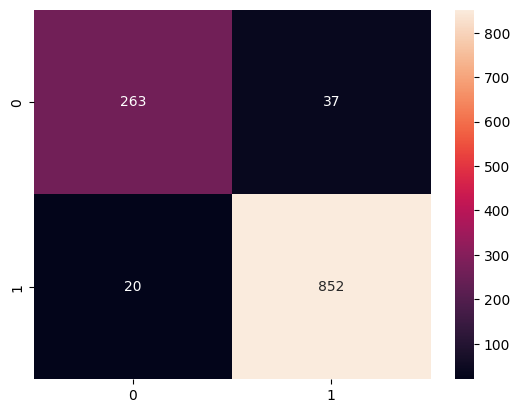

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from joblib import parallel_backend

model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=4, scoring=general_scoring, refit="f1", verbose=10, return_train_score=True)
with parallel_backend('multiprocessing'):
    grid_search.fit(datasetX, datasetY)

print("best params : ", grid_search.best_params_)

model = grid_search.best_estimator_

print(cross_val(model, general_scoring))

calcul_and_show_confusion_matrix(model)